In the first part we will focus on understanding the dataset to gain insights that will allow us to pursue the main task - predicting the possibility of clients making a new order in the next 30 days.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display

from matplotlib import pyplot as plt
import pandas as pd

from utilities import df_utils

## EDA

### First glance at data

Let's start by importing the data from the csv file:

In [2]:
data_path = '../data/raw_data.csv'
df = pd.read_csv(data_path)
df_utils.df_summarise(df)

(26513, 7)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
0,1158820823102,1399261528126,2019-08-13 03:08:30,3192.00,8700,8700,4
1,1856685080638,2733349404734,2019-11-07 06:17:09,135.15,9000,9000,3
2,1994825334846,2862876164158,2019-12-25 14:47:26,288.00,8722,8722,3
3,2116997972030,2888199700542,2020-02-20 09:15:17,237.00,3650,3650,6
4,2155705139262,2992745709630,2020-03-13 22:57:46,208.00,9900,9900,3


Just a handful of columns in the dataset. Looking at them without business context we will need make some assumptions about their contents:

* `order_id` - individual order identifier
* `customer_id` - individual customer identifier
* `created_at` - date of transaction
* `total_price` - purchase price
* `shipping_zip` - the ZIP code for the transaction shipping address
* `billing_zip` - the ZIP code for the transaction billing address
* `segment` - customer segmentation using unknown criteria

First, let's check for missing data:

In [3]:
df.isna().sum()

order_id         0
customer_id      0
created_at       0
total_price      0
shipping_zip    56
billing_zip     56
segment          0
dtype: int64

Apart for some minor amount of transactions with missing ZIP codes, the data seems to be complete.

Now let's dive a little deeper into the specifics of all provided columns:

In [4]:
df.describe(include='all')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
count,2.651300e+04,2.651300e+04,26513,26513.000000,26457,26457,26513.000000
unique,NaN,NaN,21423,NaN,806,807,NaN
top,NaN,NaN,2021-04-11 19:46:42,NaN,2300,2300,NaN
freq,NaN,NaN,6,NaN,535,532,NaN
mean,3.393264e+12,3.746155e+12,NaN,366.427770,NaN,NaN,4.602195
std,5.104882e+11,1.317448e+12,NaN,372.964493,NaN,NaN,3.230504
min,1.158821e+12,1.385019e+12,NaN,0.000000,NaN,NaN,1.000000
25%,2.867443e+12,3.222644e+12,NaN,178.000000,NaN,NaN,3.000000
50%,3.670171e+12,3.657082e+12,NaN,253.000000,NaN,NaN,3.000000
75%,3.844240e+12,5.102141e+12,NaN,438.000000,NaN,NaN,7.000000


Not much valuable insight yet, which is why we'll look into the specifics for each column.

### `order_id`

Since we made an assuption that `order_id` is a unique identifier for each transaction, we can check if this is in fact true - we would therefore expect every row of the table to represent a unique transaction, with a unique `order_id`:

In [5]:
len(df['order_id'].unique()) == len(df)

False

Alas, it turns out this is not true: some of the `order_id`s appear in the dataset more than once. Let's look into this:

In [6]:
duplicated_orders = df[df['order_id'].duplicated()]['order_id'].unique()
duplicates_df = df[df['order_id'].isin(duplicated_orders)].sort_values(by='order_id')
print('Number of duplicates:', len(duplicated_orders))
display(duplicates_df.head(6))
display(duplicates_df.tail(6))

Number of duplicates: 4903


,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
1765,2758376063038,3557233721406,2020-11-06 13:25:46,1497.0,8270,8270,3
1766,2758376063038,3557233721406,2020-11-06 13:25:46,1497.0,8270,8270,3
2421,2771829981246,3568094707774,2020-11-13 09:59:59,138.0,4700,4700,6
2422,2771829981246,3568094707774,2020-11-13 09:59:59,138.0,4700,4700,6
3191,2794727374910,3587946741822,2020-11-23 09:59:08,628.0,8600,8600,3
3192,2794727374910,3587946741822,2020-11-23 09:59:08,628.0,8600,8600,3


,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
26204,4050974670910,5265087627326,2021-08-05 21:54:11,234.0,6990,6990,9
26205,4050974670910,5265087627326,2021-08-05 21:54:11,234.0,6990,6990,9
26206,4051151487038,1390765965374,2021-08-05 23:51:42,307.2,5550,5550,9
26207,4051151487038,1390765965374,2021-08-05 23:51:42,307.2,5550,5550,9
26208,4051200442430,1389376766014,2021-08-06 00:29:49,268.0,2635,2635,9
26209,4051200442430,1389376766014,2021-08-06 00:29:49,268.0,2635,2635,9


Looks like some of the transactions are doubled in our dataset! Let's correct for this now. We'll assume the combination of `customer_id` and `order_id` should be unique:

In [7]:
df = df.drop_duplicates(subset=['order_id', 'customer_id'])
df.shape

(21444, 7)

Let's check if the order uniqueness has now been achieved:

In [8]:
len(df['order_id'].unique()) == len(df)

False

Looks like this is still not the case, therefore we look at examples again:

In [9]:
duplicated_orders = df[df['order_id'].duplicated()]['order_id'].unique()
duplicates_df = df[df['order_id'].isin(duplicated_orders)].sort_values(by='order_id')
display(duplicates_df.head())

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment
14479,3708404564030,5025184153662,2021-03-31 15:54:12,178.0,5874,5874,11
14480,3708404564030,1392951656510,2021-03-31 15:54:12,178.0,5874,5874,1
20513,3857466064958,5178460799038,2021-06-11 22:31:10,263.0,6340,6340,1
20515,3857466064958,5181438787646,2021-06-11 22:31:10,263.0,6340,6340,10


We're left with two orders with more than one customer attached to them. Since we cannot rule out the possibility of some form of co-purchase (especially that the rest of the transaction detail seem to match) we will leave these in for now.

### `customer_id`

We will learn more about the customers in the feature engineering phase of this project. For now let's review the histogram for `customer_id` value counts - this will tell us how many transactions have been made by customers in the analysed period:

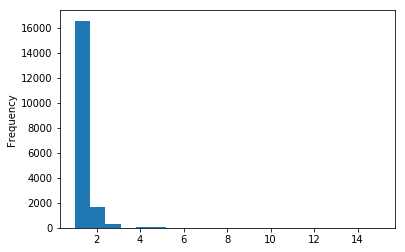

In [10]:
df['customer_id'].value_counts().plot.hist(bins=20)

Looks like the vast majority of customers only made a single purchase in the analysed period. Since the customer retention is so low we can assume the average probability of a customer making another transaction will also be very low. This will surely pose a challenge to effective forecasting of our target variable.

### `created_at`

For temporal data we can typically obtain a lot of useful information from the date itself - in particular to find answers to questions like:
* what is the time window for the analysis
* are there any time trends in the data
* is there any seasonality present in the data

Let's start by transforming `created_at` into a datetime variable and extract some features from it. To see the development of sales over time we will also create a `yearmonth` variable:

In [11]:
df['created_at'] = pd.to_datetime(df['created_at'])
intervals = ['year', 'month', 'week', 'weekday', 'day']
for interval in intervals:
    df[interval] = getattr(df['created_at'].dt, interval)
df['yearmonth'] = df['year'] * 100 + df['month']
df_utils.df_summarise(df)

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


(21444, 13)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment', 'year', 'month', 'week', 'weekday', 'day',
       'yearmonth'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,week,weekday,day,yearmonth
0,1158820823102,1399261528126,2019-08-13 03:08:30,3192.00,8700,8700,4,2019,8,33,1,13,201908
1,1856685080638,2733349404734,2019-11-07 06:17:09,135.15,9000,9000,3,2019,11,45,3,7,201911
2,1994825334846,2862876164158,2019-12-25 14:47:26,288.00,8722,8722,3,2019,12,52,2,25,201912
3,2116997972030,2888199700542,2020-02-20 09:15:17,237.00,3650,3650,6,2020,2,8,3,20,202002
4,2155705139262,2992745709630,2020-03-13 22:57:46,208.00,9900,9900,3,2020,3,11,4,13,202003


Let's plot the individual temporal features in the context of:
* number of transactions (count)
* total transaction amount (sum)
* average transaction amount (mean)

YEAR


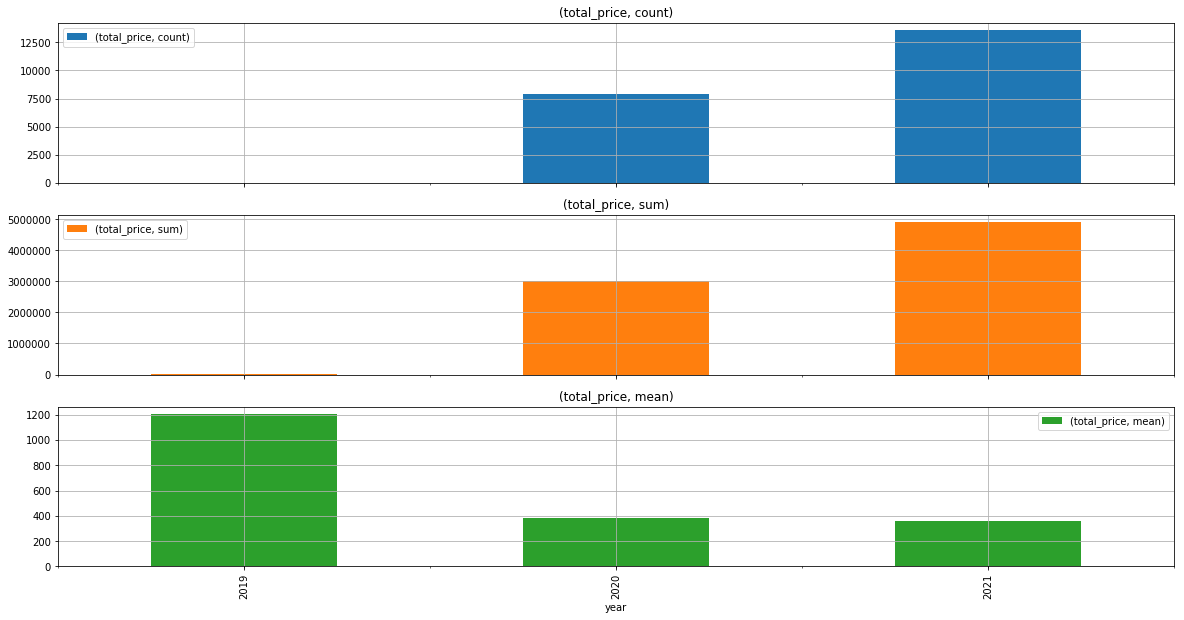

YEARMONTH


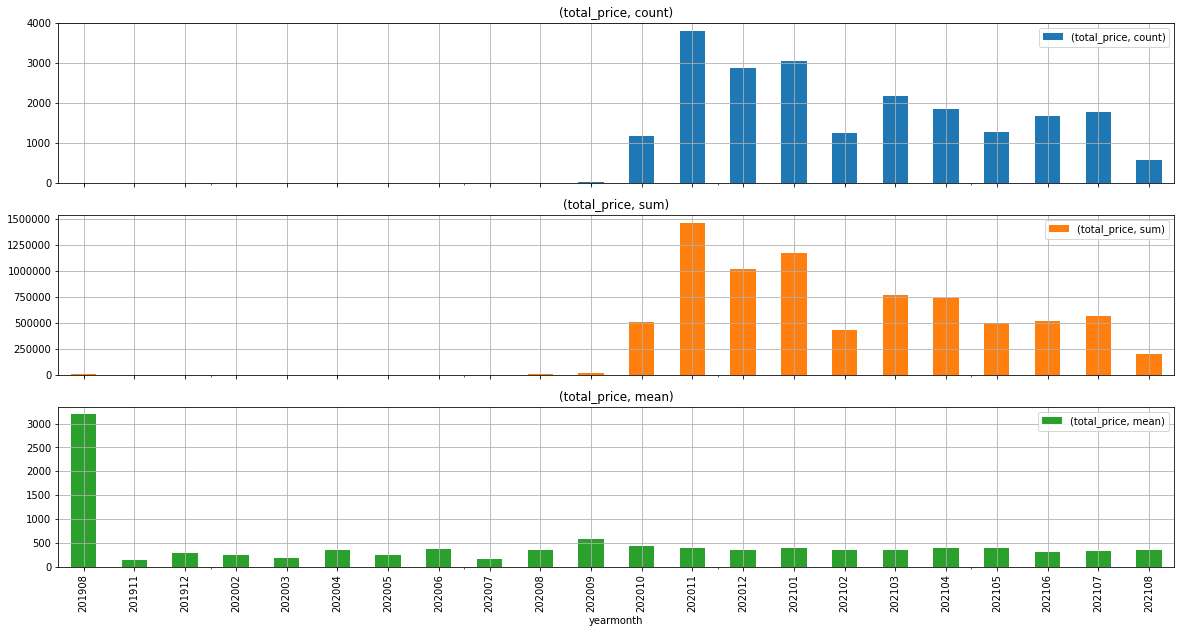

MONTH


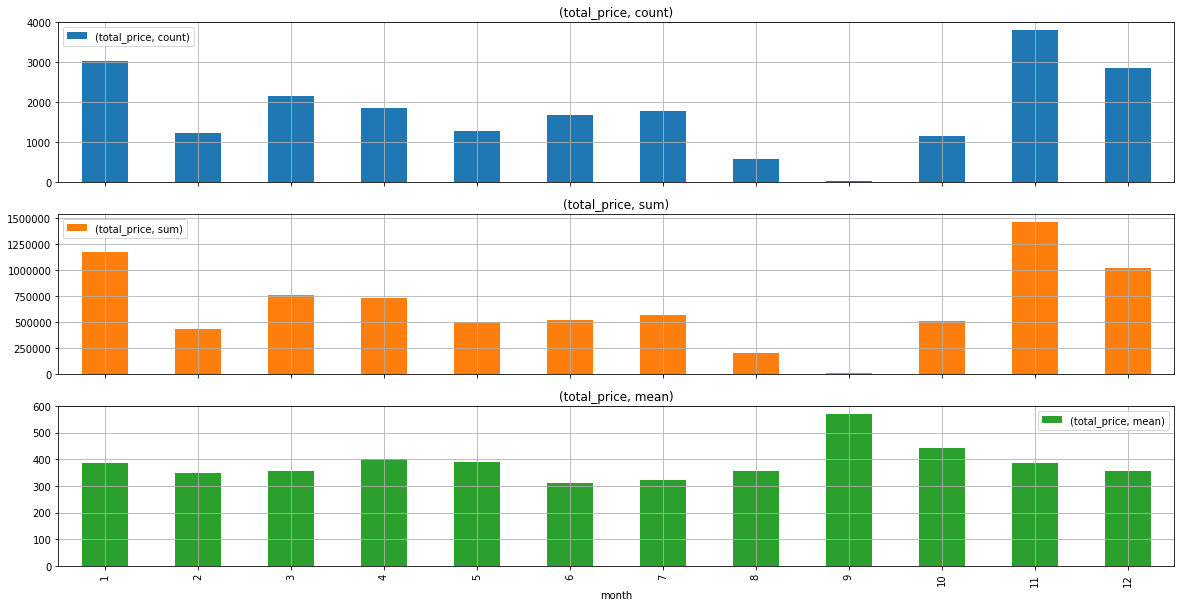

WEEK


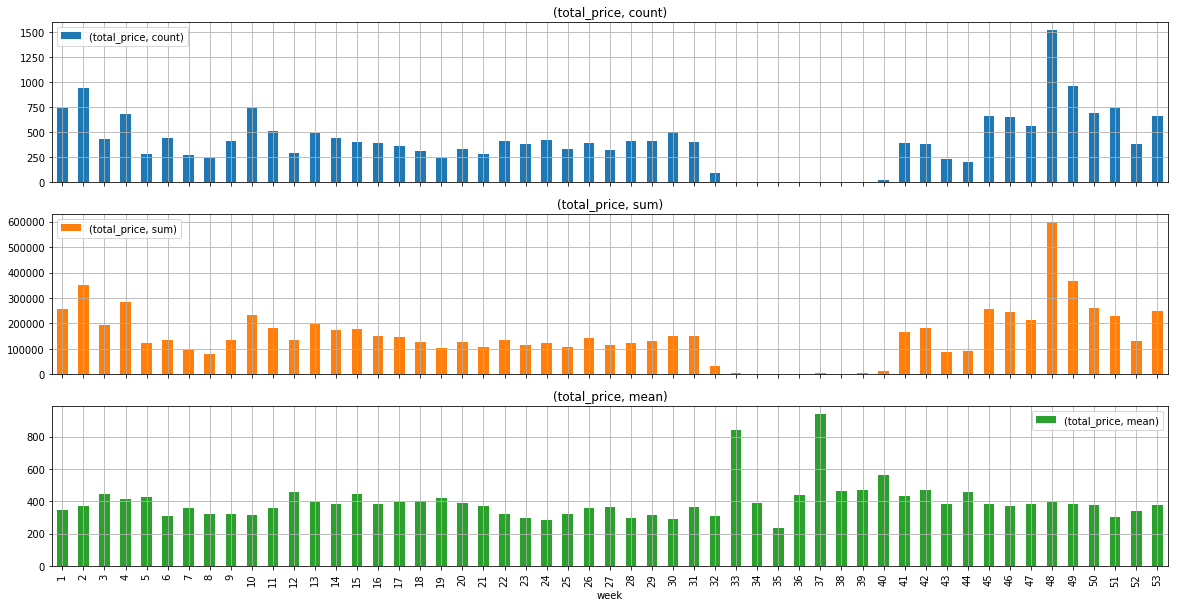

WEEKDAY


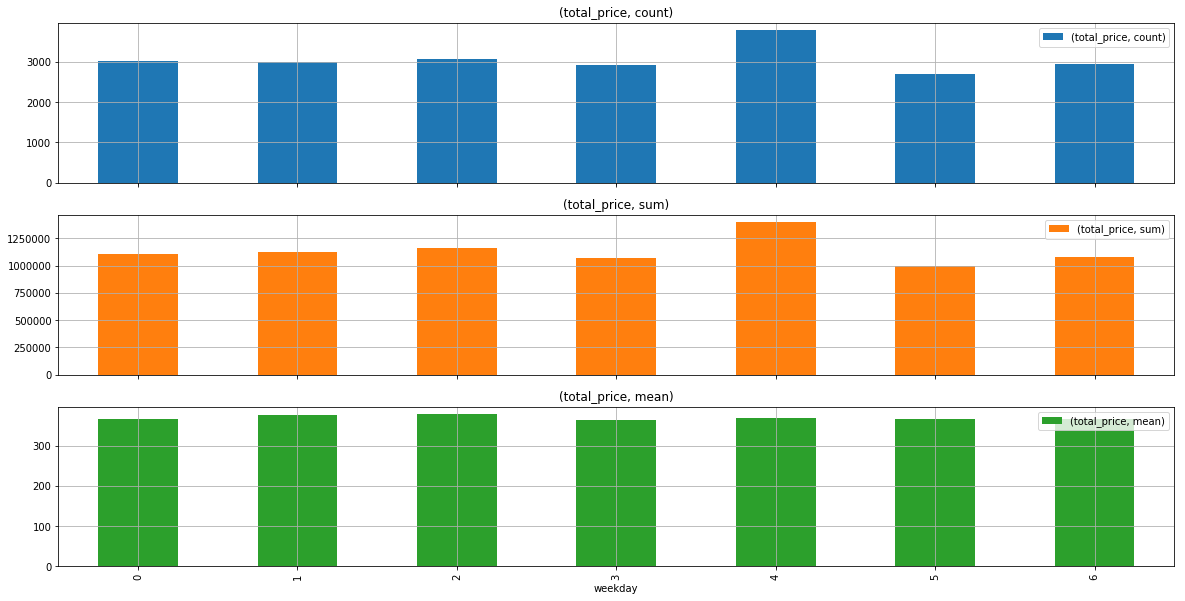

DAY


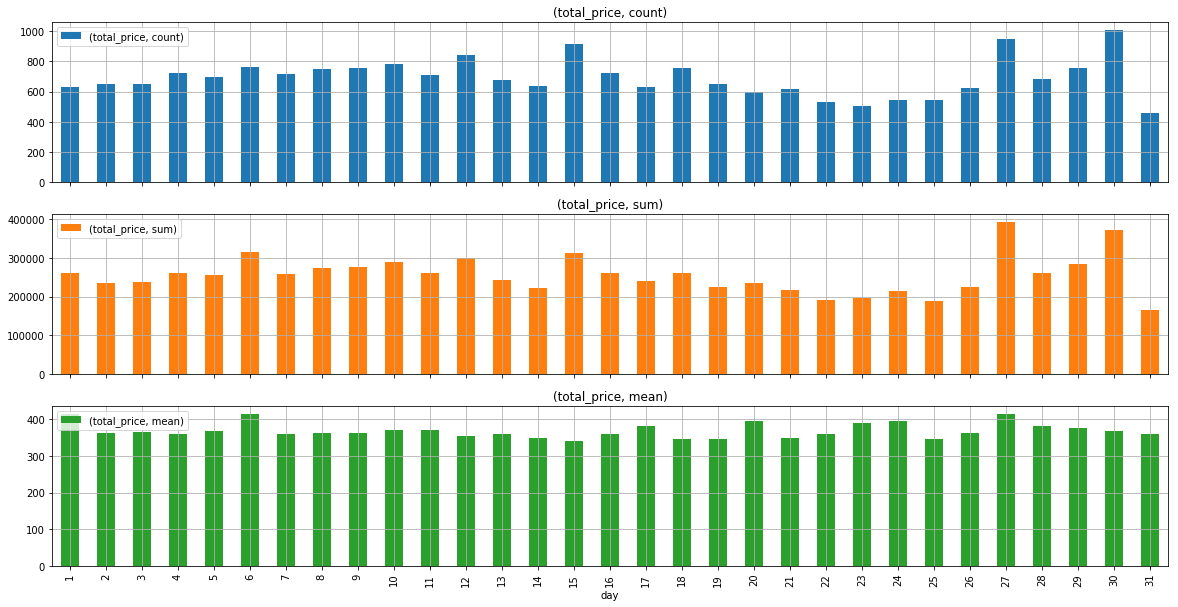

In [12]:
figsize = (20, 10)

for interval in ['year', 'yearmonth', 'month', 'week', 'weekday', 'day']:
    print('='*60)
    print(interval.upper())
    agg_df = df_utils.aggregate(df, interval)
    agg_df.plot(kind='bar', grid=True, subplots=True, sharex=True, figsize=figsize)
    plt.show()

Things to note:
* while in theory the dataset spans three years - 2019-21 - in practice the vast majority of activity happens between Nov 2020 and Jun 2021, giving us less than a year of valid data

* in light of the above, any comments about seasonality in the data should be made with caution

### `billing_zip` and `shipping_zip`

The shipping and billing address are the same more tha 99% of the time:

In [13]:
(df['billing_zip'] == df['shipping_zip']).astype(int).describe()

count    21444.000000
mean         0.993005
std          0.083345
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

Since they are so highly correlated, this typically means including only one in modelling should prove to be enough.

From the initial EDA we know there are over 800 unique ZIP codes in our dataset - from the looks of it, probably Danish. Since ZIP codes are in their nature categorical (i.e. there is no greater/lesser relationship between two distinct ZIP codes), this would mean we need over 800 dummy variables in our set!

One way of tackling this would be to aggregate these ZIP codes by location - typically a generic location already gives a lot of insight into the analysis. We can use the fact Danish (and most other) ZIP codes are hierarchical, with the initial digits representing a generic area. We'll use this knowledge in our helper function `get_zip_code_stem` and see if we can benefit from such aggregation:

In [14]:
df['billing_zip_stem'] = df['billing_zip'].apply(df_utils.get_zip_code_stem)
df['billing_zip_stem'].unique().shape

(118,)

We managed to reduce the number of individual categories down to just above 100 which is promising. Let's plot the ZIP stems in a similar fashion to the temporal data:

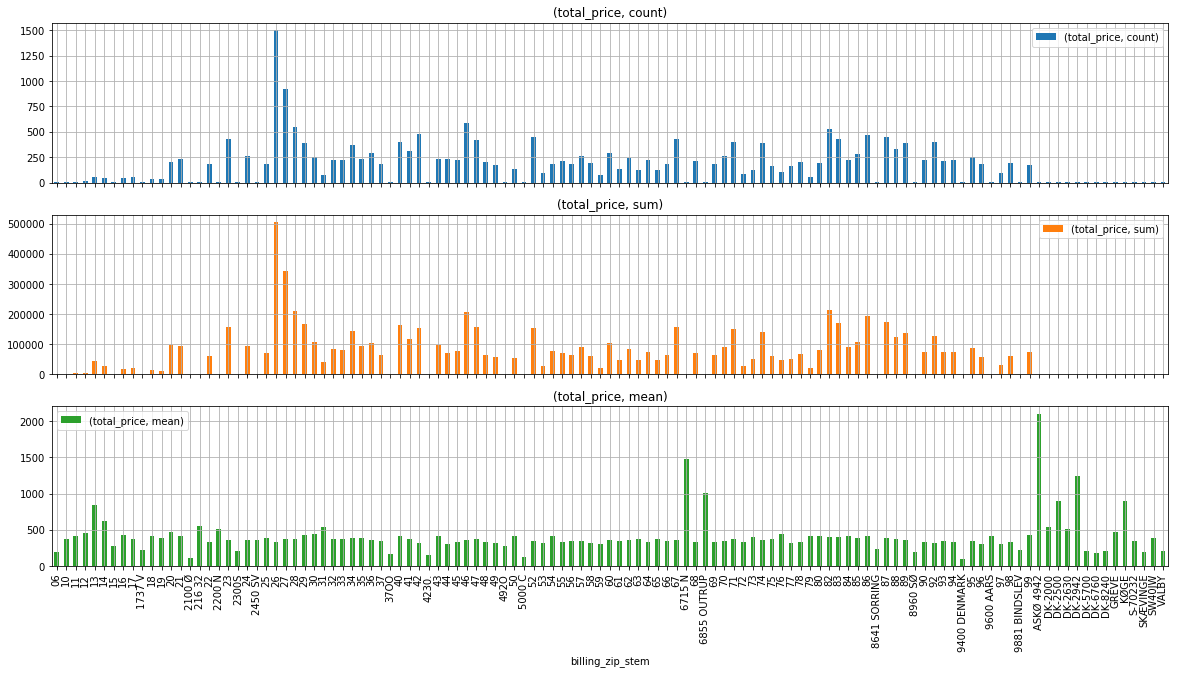

In [15]:
agg_df = df_utils.aggregate(df, 'billing_zip_stem')
agg_df.plot(kind='bar', grid=True, subplots=True, sharex=True, figsize=figsize)
plt.show()

There seems to be a concentration of sales for areas 26 and 27 - which if my hunch about Denmark is correct would mean areas just outside Copenhagen.

### `segment`

Let's see if we can get some insight from the vague `segment` variable - in particular with respect to the number of transactions, their total and mean values:

In [16]:
df[['total_price', 'segment']].groupby('segment').describe()

total_price                                                          \
              count        mean         std   min     25%     50%       75%   
segment                                                                       
1            4005.0  230.890654  126.305871   0.0  158.00  188.00   273.000   
3           10543.0  386.276524  370.256683   0.0  187.50  300.99   463.150   
4             685.0  963.546818  706.463002  39.0  445.26  834.00  1194.000   
6            1763.0  372.043330  326.168844   0.0  188.95  313.00   438.000   
7             675.0  532.891926  796.271078   0.0  178.00  318.95   526.500   
9            1695.0  271.292897  219.088858   0.0  168.00  198.00   317.950   
10            683.0  582.032167  277.031110   0.0  439.60  516.80   724.075   
11           1395.0  284.201290  197.978870  14.0  178.00  232.00   348.475   

                   
              max  
segment            
1         1518.00  
3        13133.25  
4         5877.75  
6         3480.00  
7         9452.00  
9         2199.00  
10        2694.00  
11        2370.00

For now no clear pattern is visible with respect to either count or transaction value.

This concludes the EDA part - from here we will move on to the feature engineering part of our project.